**$T_1.$** Soit $X_1$, ..., $X_n$ des variables aléatoires iid de loi $\mathcal{N}(\theta, 1)$, où $\theta$ est inconnu.
1.  (a) Montrer que $\widehat{\theta_n} = \frac{1}{n} \sum\limits_{k=1}^{n}X_k$ converge presque sûrement vers $\theta$.
    
    (b) Déterminer la loi de $\sqrt{n}(\widehat{\theta_n} - \theta)$.
1. Soit $\alpha$ $\in$ $]0, \;1[$ fixé et $\Phi$ la fonction répartition de la loi Gaussienne $\mathcal{N}(\theta, 1)$. Déterminer en fonction de $\alpha$, de $n$, de $\Phi^{-1}$ et de $\theta_0$ la valeur optimale de $K_\alpha$ pour que la relation $\mathbb{P}_{\theta = \theta_0}(T_K=1) \leq \alpha$ soit satisfaite avec une égalité.


//TODO T1 1.a, 1.b, 2

**$S_1.$** Créer un code python permettant:
1. de simuler $n$ variables gaussiennes indépendantes de loi $\mathcal{N}(\theta_0, 1)$,
1. de calculer pour $\alpha$ et $\theta_0$ fixés, la constante $K_\alpha$ et qui vous renvoie la valeur optimale de votre règle
de décision.
1. Pour $\theta_0 = 3$, $\alpha = 0.05$ et $n = 100$ répéter $N = 100$ fois l’expérience et compter le nombre fois où
vous avez décidé $H_0$. On appelle ce nombre $N_n$ quelle est sa loi?
1. Pour $n \in \{100,\; 1000\}$ et $N \in \{100, 1000, 5000\}$, Simuler $500$ valeurs de la variable aléatoire $N_n$ et
les représenter sous forme d’histogramme. Que remarquez-vous?

In [73]:
# Imports
import math
import random
from typing import List, Callable

import numpy as np
from scipy.special import erfinv
from scipy.stats import binom
import matplotlib.pyplot as plt

In [74]:
# S1.1
def n_gauss_iid(theta0: float, n: int) -> np.ndarray:
    """Generates n independent gaussian random variables of standard deviation 1 and average theta0.

    Args:
        theta0 (float): average value
        n (int): number of random variables to generate.
    Returns:
        np.ndarray: array with sample of n independent gaussian random variables.
    """
    sigma = 1
    return np.random.normal(theta0, sigma, n)

In [75]:
# S1.2
def phi_inv(p: float) -> float:
    """Quantile function (inverse of the cumulative function) of the standard normal distribution.

    Args:
        p (float): probability (p in ]0, 1[)

    Returns:
        float: x which phi(x) = p
    """
    return math.sqrt(2.)*erfinv(2.*p - 1.)

def get_k_alpha(theta0: float, alpha: float, n: int) -> float:
    """Calculates the optimal alpha for a decision with probability alpha of false negatives.

    Args:
        theta0 (float): average value
        alpha (float): upper limit of probability of chosing H1 given that H0 is true (false negative)
        n (int): sample size

    Returns:
        float: optimal value K alpha
    """
    return phi_inv(alpha)/math.sqrt(n) + theta0

In [76]:
# S1.3

def theta_estimator(x: np.ndarray) -> float:
    """Estimator for theta

    Args:
        x (np.ndarray): independant samples of random variable

    Returns:
        float: estimated theta value
    """    
    return x.mean()

def decision_rule(x: np.ndarray, k: float) -> bool:
    """Outputs the decision. 0 if H0 and 1 if H1 are chosen

    Args:
        x (np.ndarray): samples of random variable
        k (float): decision threshold

    Returns:
        bool: decision result (True = H1, False = H0)
    """    
    return theta_estimator(x) < k

def simulate_Nn(theta0: float, alpha: float, n: int, N: int) -> int:
    """Simulates Nn, the count of the times H0 is decided
    **It follows a Binomial distribution ~ B(N, 1 - alpha)**
    Because we have a binary choice of deciding H0 or not with a probability of 1 - alpha
    Each trial follows a Bernoulli distribution of p = 1 - alpha and is independent
    Therefore the sum follows a Binomial distribution

    Args:
        theta0 (float): average value
        alpha (float): false negative probability
        n (int): number of samples of each trial
        N (int): number of trials

    Returns:
        int: count of how many times H0 was decided
    """    
    k_alpha = get_k_alpha(theta0, alpha, n)
    return N - sum(decision_rule(n_gauss_iid(theta0, n), k_alpha) for _ in range(N))



In [77]:
theta0 = 3.
alpha = 0.05
n = 100
N = 100

simulate_Nn(theta0, alpha, n, N)

96

In [78]:
# S1.4
def binomial_dist_pmf(n_trials: int, prob: float, start: int=0, end:int= None, scale: float=1.) -> tuple[np.ndarray, np.ndarray]:
    """Calculates the x and y axis of the probability mass function of a binomial distribution

    Args:
        n_trials (int): number of trials
        prob (float): probability of Bernoulli
        start (int, optional): Start of x axis. Defaults to 0.
        end (int, optional): End of x axis. None means n_trials. Defaults to None.
        scale (float, optional): Scaling factor. Defaults to 1..

    Returns:
        Tuple[np.ndarray, np.ndarray]: x and y axis of the probability mass function
    """    
    if end is None:
        end = n_trials
    x = np.array(range(start, end + 1))
    
    y = scale*binom.pmf(x, n_trials, prob)
    return x, y


def plot_Nn(Ns: List[int], ns: List[int], theta0: float, alpha: float, num_values: int, plot_width: float) -> None:
    """Plots the simulation of the histogram Nn

    Args:
        Ns (List[int]): List of number of trials
        ns (List[int]): List of number of samples of each trial
        theta0 (float): average value
        alpha (float): false negative probability
        num_values (int): Number of values of Nn sampled for each case
        plot_width (float): Plot width in inches
    """    
    fig, axs = plt.subplots(len(ns), len(Ns))
    fig.suptitle("Distribution of $N_n$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_width*len(ns)/len(Ns))

    for i, n in enumerate(ns):
        for j, N in enumerate(Ns):
            test = [simulate_Nn(theta0, alpha, n, N) for _ in range(num_values)]
            Nn_min = min(test)
            Nn_max = max(test)
            counts, bins = np.histogram(test, bins=Nn_max - Nn_min + 1)
            axs[i, j].stairs(counts, bins, fill=True, label="simulation", color="navy")
            axs[i, j].plot(
                *binomial_dist_pmf(N, 1. - alpha, Nn_min, Nn_max, num_values),
                label="theory", color="crimson", linestyle="dashed", linewidth=3
            )
            axs[i, j].set_title(f"n = {n}, N = {N}")
            axs[i, j].legend(loc="upper left")

    plt.show()

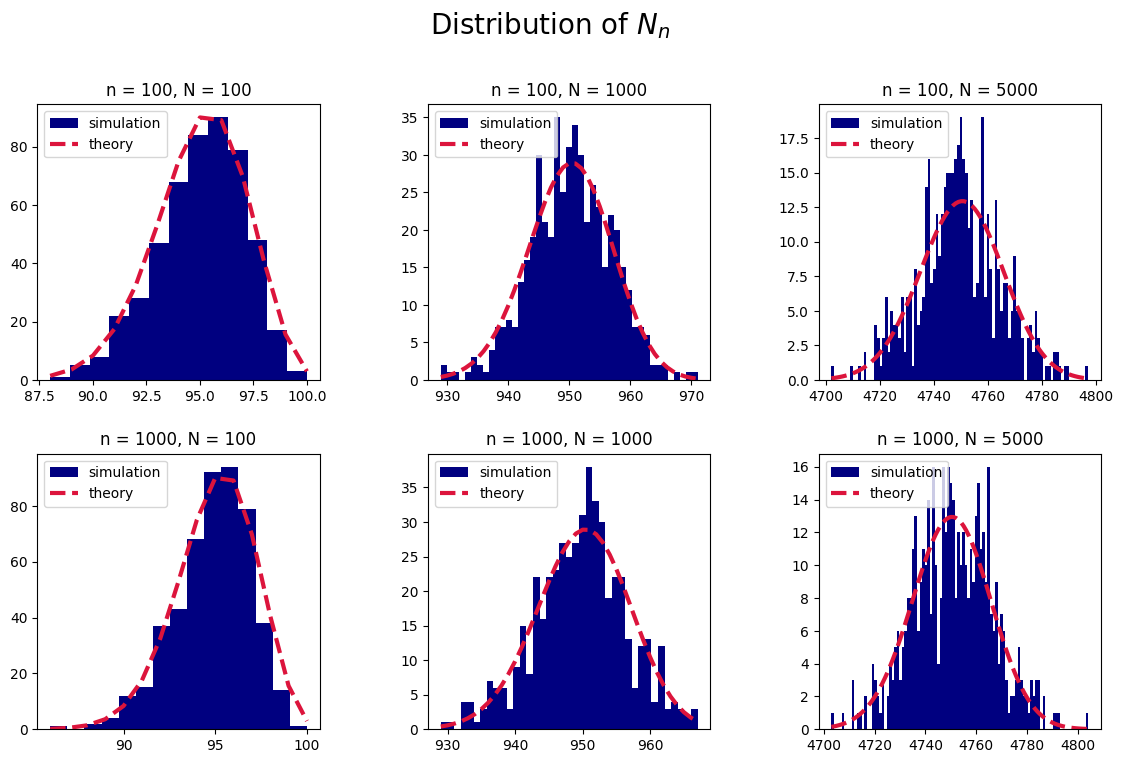

In [79]:
theta0 = 3.
alpha = 0.05
ns = [100, 1000]
Ns = [100, 1000, 5000]
num_values = 500
plot_width = 12

plot_Nn(Ns, ns, theta0, alpha, num_values, plot_width)

# The distribution of Nn closely matches our predicted Binomial distribuition in all cases
# In general, increasing n seems to slightly reduce the noise of the data and makes it follow the theorical curve more closely
# Increasing N clearly makes the results more noisy as we don't increase the number of values of Nn accordingly
# and we kept each histogram bucket with a width of 1.

S2

In [130]:
def func_f(
    x: np.ndarray, b: float, c: float, x_prime: np.ndarray|None = None,
    u: set|None = None
) -> float:
    assert x.size == 4
    assert x_prime is None or x_prime.size == 4
    if u is None:
        aux_x = np.copy(x)
    else:
        aux_x = np.array([x[i] if i + 1 in u else x_prime[i] for i in range(0, x.size)])
    return np.sum(aux_x) + aux_x[0]*aux_x[1]*(b + c*aux_x[2])

def calc_y(x: np.ndarray, func: Callable) -> float:
    return func(x=x)

def calc_y_u(x: np.ndarray, x_prime: np.ndarray , func: Callable, u: set) -> float:
    return func(x=x, x_prime=x_prime, u=u)

def calc_ys(xs: List[np.ndarray], func: Callable) -> np.ndarray:
    return np.array([calc_y(x, lambda x : func(x=x, x_prime=None, u=None)) for x in xs])

def calc_ys_u(xs: List[np.ndarray], xs_prime: List[np.ndarray] , func: Callable, u: set) -> np.ndarray:
    return np.array([calc_y_u(x, x_prime, func, u) for x, x_prime in zip(xs, xs_prime)])

def estimateur_s(ys: np.ndarray, ys_u = np.ndarray) -> float:
    return (np.mean(ys*ys_u) - np.mean(ys)*np.mean(ys_u))/(np.mean(np.square(ys) - np.mean(ys)**2))

def estimate_su_sv(xs: List[np.ndarray], xs_prime: List[np.ndarray], u:set, v:set , func: Callable) -> tuple[float, float]:
    ys = calc_ys(xs, func)
    ys_u = calc_ys_u(xs, xs_prime, func, u)
    ys_v = calc_ys_u(xs, xs_prime, func, v)

    su = estimateur_s(ys, ys_u)
    sv = estimateur_s(ys, ys_v)
    return  su, sv

In [139]:
n = 10000
u = {1, 2, 3}
v = {1, 2}
theta0 = 0
len_x = 4
def get_x_samples(n:int, len_x:int, theta0:float) -> tuple[np.ndarray, np.ndarray]:
    xs = [n_gauss_iid(theta0, len_x) for _ in range(n)]
    xs_prime = [n_gauss_iid(theta0, len_x) for _ in range(n)]
    return xs, xs_prime

xs, xs_prime = get_x_samples(n, len_x, theta0)

In [141]:
b = 2
c = 3
func = lambda x, x_prime, u: func_f(x, b, c, x_prime, u)

s_nu, s_nv = estimate_su_sv(xs, xs_prime, u, v, func)

print(s_nu, s_nv)

0.9447418203786202 0.35759253116855727


In [142]:
b = 2
c = 0
func = lambda x, x_prime, u: func_f(x, b, c, x_prime, u)

s_nu, s_nv = estimate_su_sv(xs, xs_prime, u, v, func)

print(s_nu, s_nv)

0.8783390320060503 0.7509777344858377


S3

In [168]:
def data_su_sv(n_min:int, n_max:int, b: float, c: float, u: set, v:set, num_points:int = 20) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    ns = np.linspace(n_min, n_max, num=num_points, dtype=np.int64)
    func = lambda x, x_prime, u: func_f(x, b, c, x_prime, u)
    ss_nu = []
    ss_nv = []
    for n in ns:
        xs, xs_prime = get_x_samples(n, len_x=4, theta0=0)
        ys = calc_ys(xs, func)
        ys_u = calc_ys_u(xs, xs_prime, func, u)
        ys_v = calc_ys_u(xs, xs_prime, func, v)
        ss_nu.append(estimateur_s(ys, ys_u))
        ss_nv.append(estimateur_s(ys, ys_v))
    ss_nu = np.array(ss_nu)
    ss_nv = np.array(ss_nv)
    return ns, ss_nu, ss_nv

def plot_snu_snv(n_min:int, n_max:int, consts: List[tuple[float, float]], u: set, v:set, plot_width: float, plot_height: float) -> None:

    random.seed(0)

    fig, axs = plt.subplots(len(consts))
    fig.suptitle("Curves of $S_n^u$, $S_n^v$", size=20)
    fig.tight_layout()
    fig.set_size_inches(plot_width, plot_height)

    for i, const in enumerate(consts):
        b, c = const
        ns, ss_nu, ss_nv = data_su_sv(n_min, n_max, b, c, u, v)
        
        axs[i].set_title(f"b = {b}, c = {c}")
        axs[i].plot(ns, ss_nu, label="$S_n^u$", color="navy", linewidth=3
        )
        axs[i].plot(ns, ss_nv, label="$S_n^v$", color="crimson", linewidth=3
        )
        axs[i].legend()
        axs[i].set_ylim([0., 1.])

    plt.show()
        
    
    



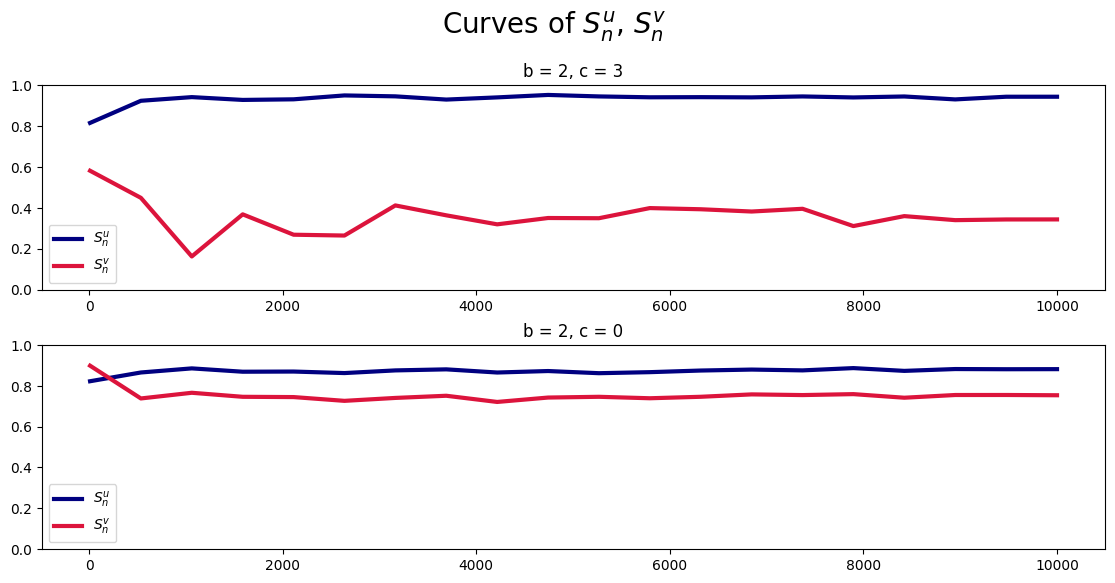

In [179]:
n_min = 10
n_max = 10000
consts = [(2, 3), (2, 0)]
u = {1, 2, 3}
v = {1, 2}
plot_width = 12.
plot_height = 6.

plot_snu_snv(n_min, n_max, consts, u, v, plot_width, plot_height)

# The curves are coherent with the results that the estimators converge almost surely to (Su, Sv)
# Because each curve "converges visually" to a fixed value that is between 0 and 1, so to a possible value of Su/Sv
# The values of convergence are also coherent from what we would expect from Su/Sv.
# For example, S_u^n converges to a bigger value than S_v^n, because v is in u.
# Comparing between the different values of c, this also happens.
# When c = 3, X3 is very important, because it is part of the product, so S_u^n tends to be way bigger than S_v^n
# However, when c = 0, X3 is only in the simple sum and it's not that influent and S_u^n tends to be much closer to S_v^n

S4

In [206]:
def calc_z(y: float, y_u: float, y_v: float) -> np.ndarray:
    return np.array([y, y_u, y_v, y*y_u, y*y_v, y**2])

def calc_zs(ys: np.ndarray, ys_u: np.ndarray, ys_v: np.ndarray) -> np.ndarray:
    return np.array([calc_z(y, y_u, y_v) for y, y_u, y_v in zip(ys, ys_u, ys_v)])

def estimate_cov_z(zs: np.ndarray) -> np.ndarray:
    return np.cov(zs.T)

def estimate_m_z(zs: np.ndarray) -> np.ndarray:
    return np.mean(zs, axis=0)

def calc_jacobian_phi(x: np.ndarray) -> np.ndarray:
    assert x.size == 6
    return np.array([
        [(-x[1]*(x[5] - x[0]**2) + 2*x[0]*(x[3] - x[0]*x[1]))/(x[5] - x[0]**2)**2, -x[0]/(x[5] - x[0]**2), 0, 1/(x[5] - x[0]**2), 0, (x[0]*x[1] - x[3])/(x[5] - x[0]**2)**2],
        [(-x[2]*(x[5] - x[0]**2) + 2*x[0]*(x[4] - x[0]*x[2]))/(x[5] - x[0]**2)**2, 0, -x[0]/(x[5] - x[0]**2), 0, 1/(x[5] - x[0]**2), (x[0]*x[2] - x[4])/(x[5] - x[0]**2)**2]
    ])

def estimate_cov_su_sv(ys: np.ndarray, ys_u: np.ndarray, ys_v: np.ndarray) -> np.ndarray:
    zs = calc_zs(ys, ys_u, ys_v)

    sigma = estimate_cov_z(zs)
    m = estimate_m_z(zs)
    jac = calc_jacobian_phi(m)
    return jac@sigma@jac.T